# Reading a image

In [119]:
# !wget https://www.dropbox.com/s/1981leemr7r5stnm/Hemanvi.jpeg

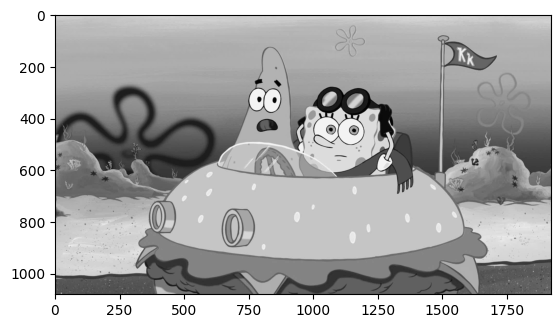

In [120]:
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread("/l/disk0/ghenrique/Documents/Pytorch_book/code/bob.jpg")
if img is None:
    print("Couldn't load image")

# Crop image
# img = img[50:250, 40:240]

# Convert image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show image
plt.imshow(img_gray, cmap="gray")
cv2.waitKey(0)
cv2.destroyAllWindows()

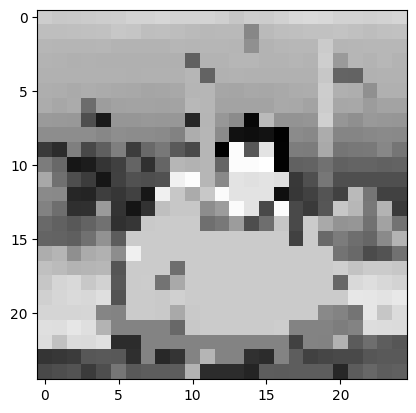

In [121]:
# Resizing the picture
img_gray_small = cv2.resize(img_gray, (25, 25))
plt.imshow(img_gray_small, cmap="gray")

In [122]:
# Let's check the values
print(img_gray_small)

[[199 195 196 197 199 200 205 206 208 204 204 205 201 193 199 198 203 209
  211 209 204 204 202 204 207]
 [185 185 186 187 188 194 192 185 186 184 182 180 181 181 134 182 185 186
  188 188 190 187 184 187 188]
 [178 177 177 177 178 176 176 176 176 178 177 178 178 177 143 176 178 179
  179 197 177 178 179 179 179]
 [175 174 172 173 172 172 172 172 172 172  98 175 176 178 178 176 176 177
  176 200 152 178 176 179 176]
 [173 173 173 173 173 173 172 173 173 173 178 101 173 174 173 173 173 173
  173 194 102 101 173 174 174]
 [171 170 167 170 168 166 165 162 163 165 177 178 163 162 165 164 166 169
  170 199 172 171 143 172 172]
 [169 164 168 109 155 159 160 160 159 161 180 178 160 160 160 160 166 165
  160 198 164 165 154 161 160]
 [152 151 150  82  33 148 148 150 149 149  45 177 149 138  16 182 146 146
  147 202 148 142 151 149 148]
 [140 140 140 140 134 141 139 139 137 130 170 178 138  25  22  26  10 138
  135 169 133 133 135 137 136]
 [ 63  51 127  76  97 127  65 108 121  93  76 178   9 2

(1080, 1920, 3)


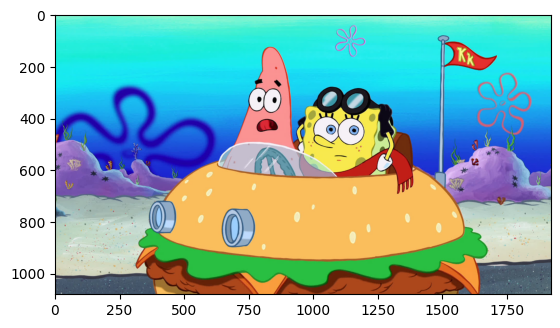

In [123]:
# Loading the colored image and sending it to rgb (opencv loads it as bgr)
img = cv2.imread("/l/disk0/ghenrique/Documents/Pytorch_book/code/bob.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)

[[[ 78  97 111]
  [ 63  82  96]
  [  0  18  32]]

 [[ 76  95 109]
  [ 62  81  95]
  [  0  16  30]]

 [[ 80  99 113]
  [ 68  87 101]
  [  6  24  38]]]


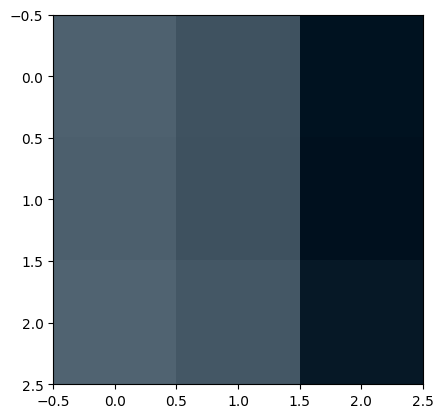

In [124]:
# Crop to the last pixel
crop = img[-3:, -3:]
print(crop)
plt.imshow(crop)

# Starting with FashionMNIst

In [125]:
from torchvision import datasets
import torch

# Define the path and download the fmnist dataset
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data'
fmnist = datasets.FashionMNIST(data_folder, download=True,
                               train=True)

In [126]:
# Separate the dataset into x and y
tr_images = fmnist.data
tr_targets = fmnist.targets

In [127]:
unique_values = tr_targets.unique()
print(f"tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY \
- {tr_targets.shape}\n\tY - Unique Values: {unique_values}")
print(f"TASK:\n\t{len(unique_values)} Class Classification")
print(f"UNIQUE CLASSES: \n\t{fmnist.classes}")

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 Class Classification
UNIQUE CLASSES: 
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


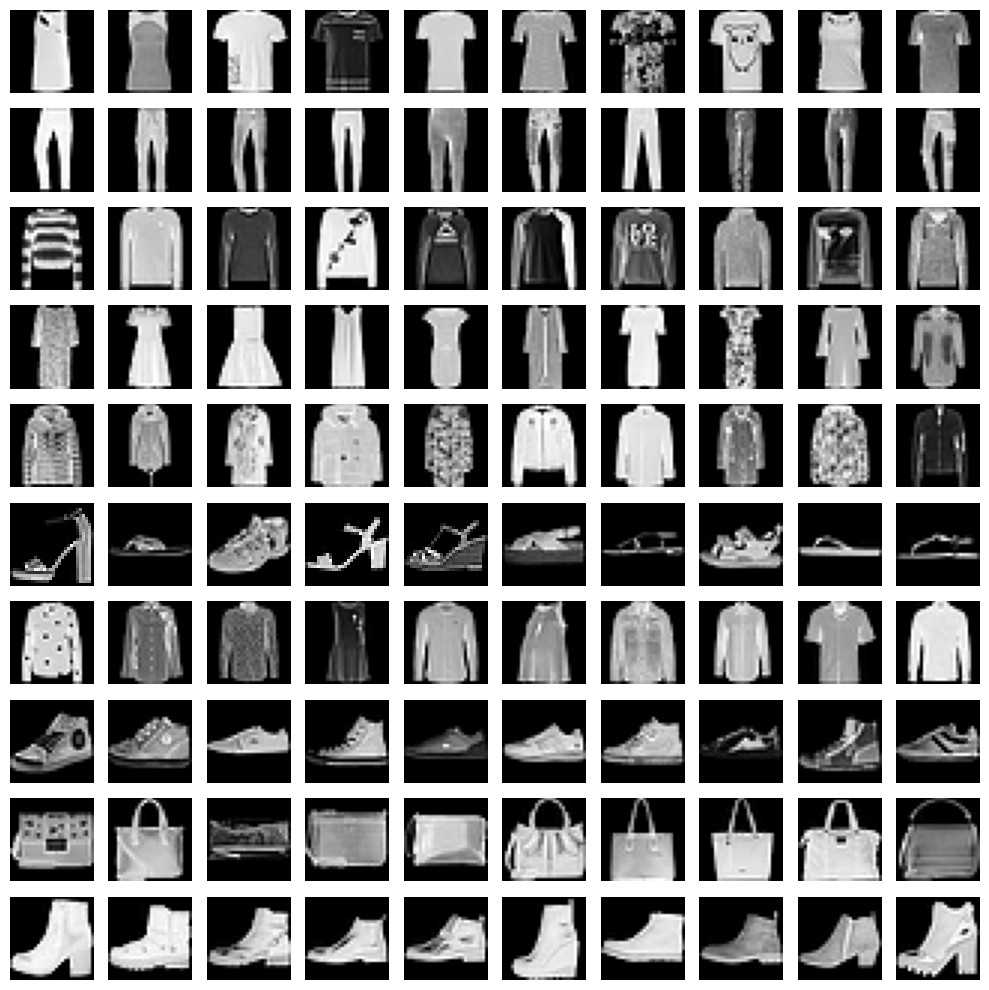

In [128]:
import numpy as np
# %matplotlib inline

# Let's plot a few random images to inspect our dataset
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10, 10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap="gray")
plt.tight_layout()


# Training a deep neural model

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets

# Download the dataset (not needed 'cause already downloaded in previous steps)
data_folder = "/l/disk0/ghenrique/Documents/Pytorch_book/code/data"
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data
tr_targets  = fmnist.targets

In [10]:
# Define the dataset class (remember that init, len and get_item functions
# must ALWAYS be defined in any dataset class)
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [11]:
from torch.optim import SGD

# Define the function to instantiate the dataset class and set it to a dataloader
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    return train_dl

# Create a function to create the model, loss_fn and optim
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=10e-3)
    return model, loss_fn, optimizer

In [12]:
# Define a training function
def train_batch(x, y, model, optim, loss_fn):
    model.train()
    
    # Do the forward operation
    prediction = model(x)

    # Calculate the loss
    batch_loss = loss_fn(prediction, y)

    # Do the backward pass
    batch_loss.backward()

    # Step the optimizer
    optim.step()

    # Flush all the gradients of the optim for the next step
    optim.zero_grad()

    return batch_loss.item()

In [13]:
# Building a function that calculates the accuracy of given dataset
@torch.no_grad() # this line ensures that we're disabling gradient computation on the entire function
def accuracy(x, y, model):
    model.eval()

    # Do the forward operation
    prediction = model(x)

    # Compute the location of maximum in each row
    # coincides with y true
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    # Return the number of correct preds
    return is_correct.cpu().numpy().tolist()

In [14]:
# Initialize model and dataset
train_dl = get_data()
model, loss_fn, optimizer = get_model()

# Invoke the lists
losses, accuracies = [], []

# Define the number of epochs
for epoch in range(3):
    print(epoch)

    # Invoke more lists
    epoch_losses, epoch_accuracies = [], []

    # Create batches of training data
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    # Calculate and store the mean across all batches within an epoch
    epoch_loss = np.array(epoch_losses).mean()

    # Calculate the accuracy of the prediction
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)

    # Store the loss and accuracy at the end of the epoch
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2


/tmp/ipykernel_5642/331491465.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


[Text(0, 0.1, '10%'),
 Text(0, 0.10500000000000001, '11%'),
 Text(0, 0.11, '11%'),
 Text(0, 0.115, '12%'),
 Text(0, 0.12000000000000001, '12%'),
 Text(0, 0.125, '12%'),
 Text(0, 0.13, '13%'),
 Text(0, 0.135, '14%')]

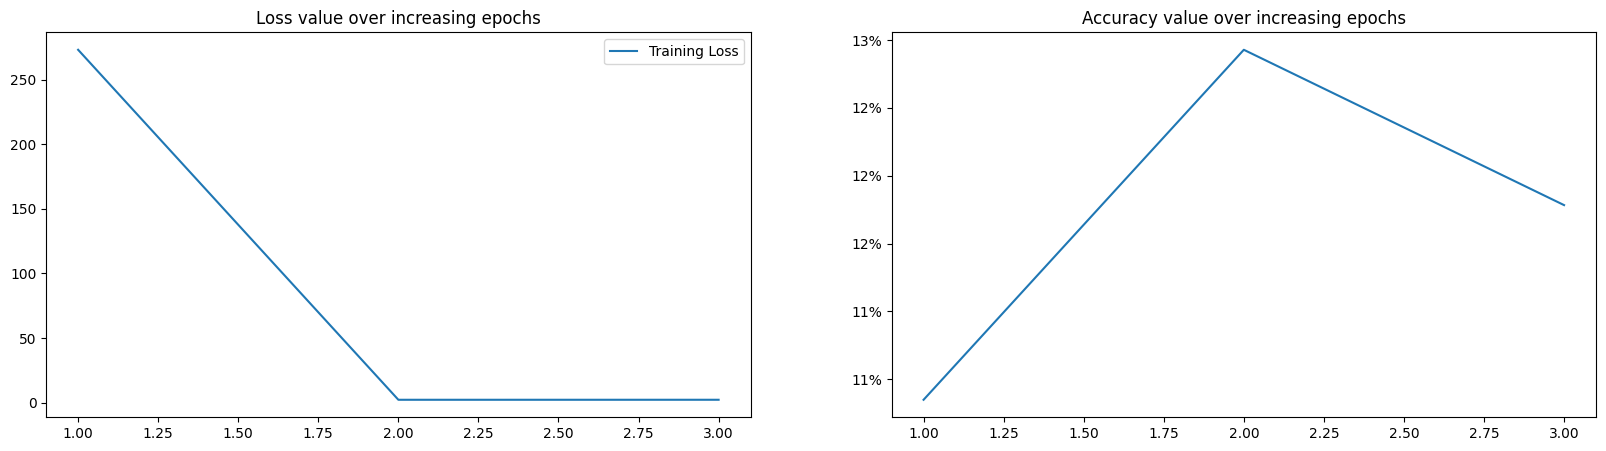

In [15]:
# Let's plot the loss and accuracy curves
epochs = np.arange(3)+1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label="Training Loss")
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()])

# Normalizing the dataset

In [16]:
# Reinstantiate the class so we normalize the pixel values
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # normalization is done here
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [17]:
# Define the data and model so we can train it just like before
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    return train_dl

In [18]:
from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [19]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    # Do the forward pass
    prediction = model(x)

    # Compute the loss
    batch_loss = loss_fn(prediction, y)

    # Do the backward loss
    batch_loss.backward()

    # Step the optimizer
    opt.step()

    # Flush the gradients for the next step
    opt.zero_grad()

    # Return the loss
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    # Do the forward pass
    prediction = model(x)

    # Check if the location of maximum in each row 
    # coincides with ground truth
    max_values, argmaxes = prediction.max(-1)

    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

In [20]:
# Instantiate data and model
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

# Invoke the arrays
losses, accuracies = [], []

for epoch in range(5):
    print(epoch)

    # Invoke epoch arrays
    epoch_losses, epoch_accuracies = [], []

    # Does the training for 1 batch using the
    # train_batch func
    for ix, batch in enumerate(iter(trn_dl)):
        x, y  = batch

        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    
    # Add the batch loss to the epoch_loss 
    # array after performing mean on all
    # losses on the batch
    epoch_loss = np.array(epoch_losses).mean()

    # Calculates the accuracy for the current batch 
    # using accuracy function
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        
        # Add the accuracy of the current batch 
        # on the array of accuracies
        epoch_accuracies.extend(is_correct) # using extend cause it is a iter obj

    # Add the accuracies and loss to the final array
    # After performing mean operation across
    # every loss/accuracy on the batch (loss is calculated on the
    # line above)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0


1
2
3
4


/tmp/ipykernel_5642/3463937114.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


[Text(0, 0.8, '80%'),
 Text(0, 0.81, '81%'),
 Text(0, 0.8200000000000001, '82%'),
 Text(0, 0.8300000000000001, '83%'),
 Text(0, 0.8400000000000001, '84%'),
 Text(0, 0.8500000000000001, '85%'),
 Text(0, 0.8600000000000001, '86%')]

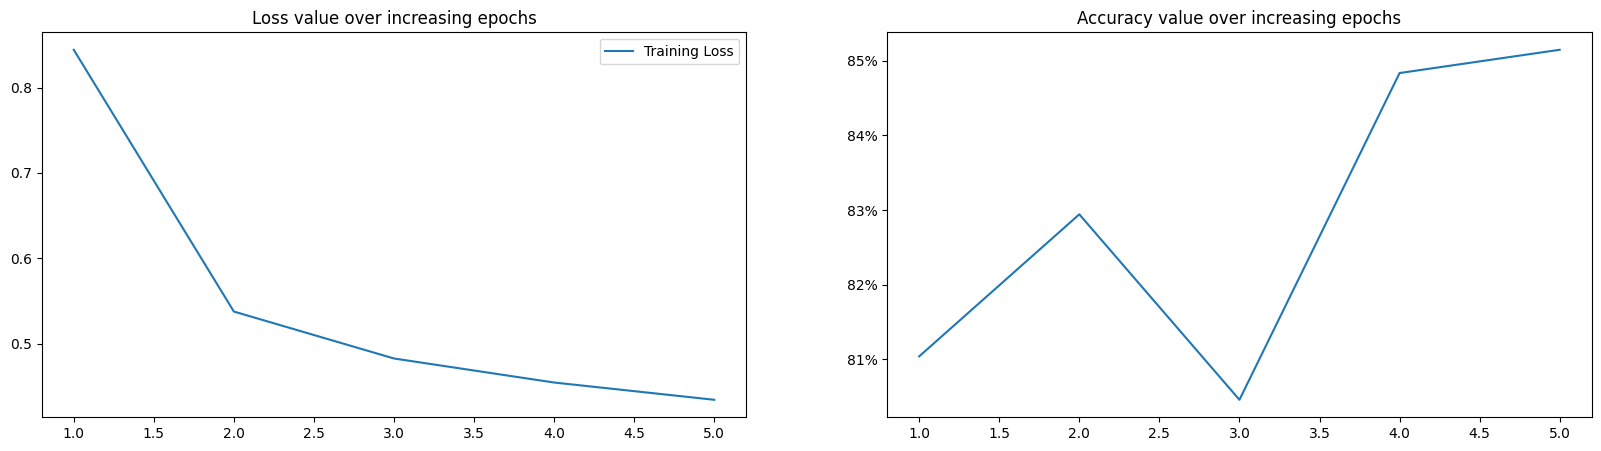

In [21]:
# Let's plot the loss and accuracy curves
epochs = np.arange(5)+1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label="Training Loss")
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()])

# Changing the batch size

Understanding the difference between using a batch size of 32 (previous experiment) and a batch size of 10000.

In [7]:
from torchvision import datasets
import torch 

# Let's reload the dataset (not download it 'cause it's already downloaded)
data_folder = "/l/disk0/ghenrique/Documents/Pytorch_book/code/data"
fmnist = datasets.FashionMNIST(data_folder, train=True, download=False)

# Reinstatiate the variables
tr_images = fmnist.data
tr_targets = fmnist.targets

# Now for the validation dataset
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import SGD, Adam

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
# Set classes for the model and the dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        # print(f"Shape de X antes a funçao view {x.shape}")
        x = x.view(-1, 28*28)
        # print(f"Shape de X após a funçao view {x.shape}")
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), 1e-2)
    return model, loss_fn, optim

def accuracy(x, y, model):
    model.eval()
    # this is the same as torch.nograd
    # but in this way grad is not computed
    # inside the with
    with torch.no_grad():
        # Do the forward pass
        prediction = model(x)
        # print(f"Prediction of the model: \n\t{prediction}")
    # Get the max values accross the prediction array
    max_values, argmaxes = prediction.max(-1)
    # print(f"This is a argmax from the function accuracy: {argmaxes}")
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [25]:
# Define the get_data
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

In [26]:
# Define a function that calculates the val loss
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [27]:
# Initialize the parameters
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

# Initialize the lists 
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [28]:
# Begin training
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []

    # Calculate the batch loss
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        
        # Append the loss to epoch losses
        train_epoch_losses.append(batch_loss)
    
    # Perform the mean operation accross the losses
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Calculate the accuracy for the batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)

        train_epoch_accuracies.extend(is_correct)
    
    # Perform the mean oepration accross the losses
    train_epoch_accuracy = np.array(train_epoch_accuracies).mean()

    # Calculate the accuracy for a batch of the val_dl
    # but since val_batch_size == len(val_dl)
    # it will perform on the whole validation dataset
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)

    # Add the mean of the accuracies into the array
    val_epoch_accuracy = np.mean(val_is_correct)

    # Append to the final arrays
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0


1
2
3
4


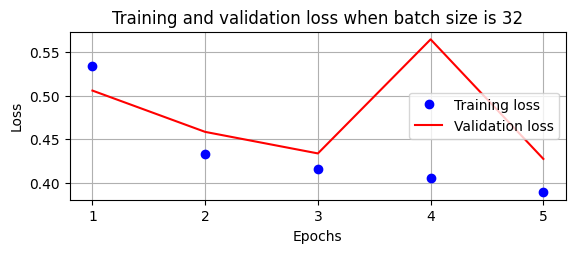

/tmp/ipykernel_5642/1316040814.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


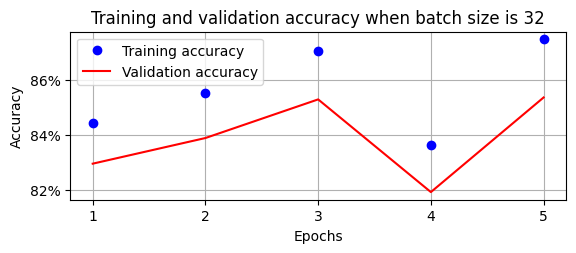

In [29]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [30]:
# Now let's change the batch size to 10000
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=10000,
                          shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=(len(val_images)),
                        shuffle=False)
    
    return train_dl, val_dl

In [31]:
# Now let's retrain the model
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

# Define the optimizer and loss_fn and model
model, loss_fn, optim = get_model()
train_dl, val_dl = get_data()

# Now let's iterate through the epochs
for epoch in range(5):
    print(epoch)
    train_epoch_accuracy, train_epoch_loss = [], []
    

    # Perform the training in a single batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_loss.append(batch_loss)
    
    # Perform the mean across every loss on the batch
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Calculate the accuracy of a single batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model) 
        train_epoch_accuracy.extend(is_correct)
    
    # Perform the mean accross every loss on the batch
    train_epoch_accuracy = np.array(train_epoch_accuracy).mean()

    # Do the same for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)

    val_epoch_accuracy = np.mean(val_is_correct)

    # Append to the final arrays
    train_accuracies.append(train_epoch_accuracy)
    train_losses.append(train_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)


0
1
2
3
4


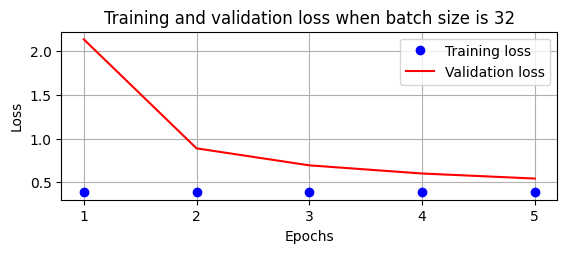

/tmp/ipykernel_5642/1316040814.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


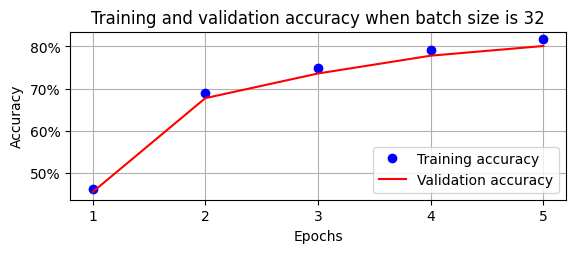

In [32]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Understanding the impact of changing the loss optimizer

In [38]:
from torch.optim import SGD
# Change the get_model() function so we use SGD instead of Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optim

# Define the get_data back with 32 of batch size
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

In [42]:
# Train the model with more epochs
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
model, loss_fn, optim = get_model()


# Double the amount of epochs
for epoch in range(20):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []

    # Perform the training on one batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_losses.append(batch_loss)
    # Add to the array
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Same for accuracy
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Now for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_accuracy = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


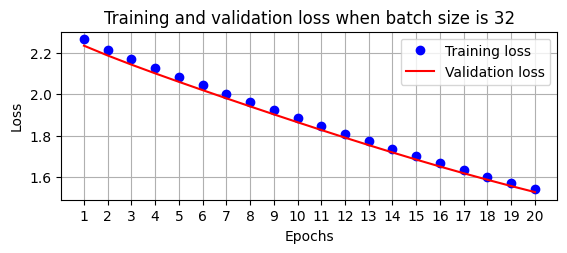

/tmp/ipykernel_5642/2754648071.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


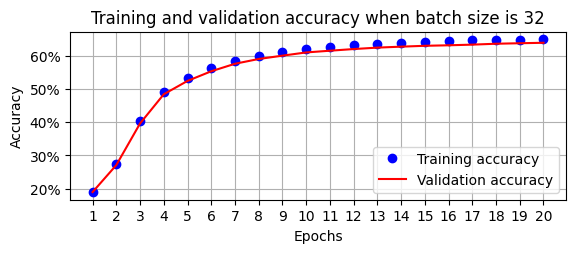

In [43]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Now the same for Adam optim

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


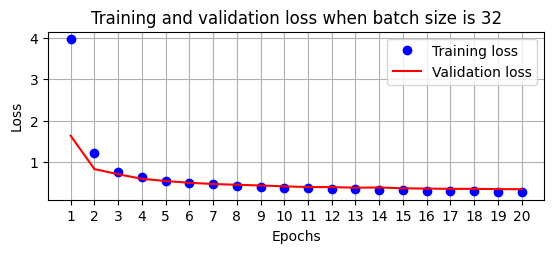

/tmp/ipykernel_5642/2074760309.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


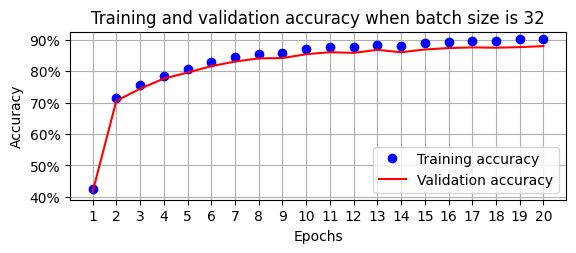

In [44]:
from torch.optim import SGD
# Change the get_model() function so we use SGD instead of Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optim

# Define the get_data back with 32 of batch size
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

# Train the model with more epochs
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
model, loss_fn, optim = get_model()


# Double the amount of epochs
for epoch in range(20):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []

    # Perform the training on one batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_losses.append(batch_loss)
    # Add to the array
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Same for accuracy
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Now for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_accuracy = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)


epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Understanding the impact of the learning rate

## High learning rate

In [51]:
# We need to redenify the get_model function so we can change the lr
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    optim = Adam(model.parameters(), lr=1e-1)
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn, optim

0
1
2
3
4
5
6
7
8
9


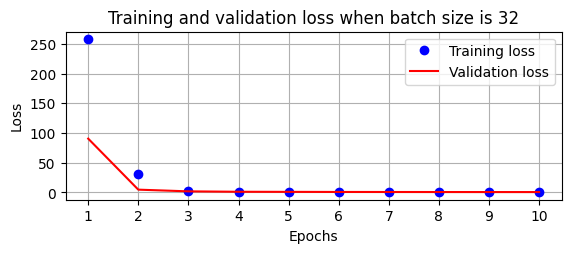

/tmp/ipykernel_5642/442740823.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


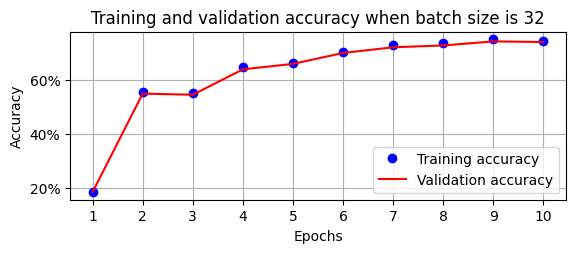

In [52]:
# Now we just train the model like before

# Define the get_data back with 32 of batch size
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

# Train the model with more epochs
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
model, loss_fn, optim = get_model()


# Double the amount of epochs
for epoch in range(10):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []

    # Perform the training on one batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_losses.append(batch_loss)
    # Add to the array
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Same for accuracy
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Now for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_accuracy = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)


epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Medium learning rate

In [53]:
# Redefine the get_model function to lower the lr
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    optim = Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn, optim

0
1
2
3
4
5
6
7
8
9


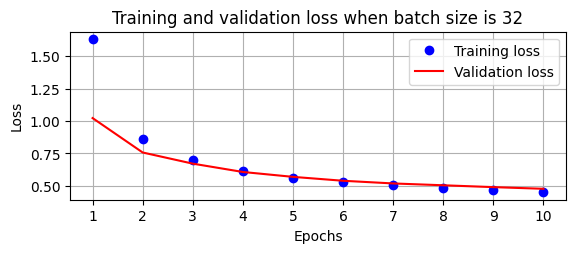

/tmp/ipykernel_5642/442740823.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


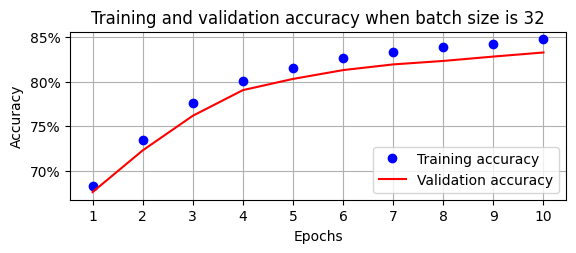

In [54]:
# Now we just train the model like before

# Define the get_data back with 32 of batch size
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

# Train the model with more epochs
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
model, loss_fn, optim = get_model()


# Double the amount of epochs
for epoch in range(10):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []

    # Perform the training on one batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_losses.append(batch_loss)
    # Add to the array
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Same for accuracy
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Now for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_accuracy = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)


epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Low learning rate        

In [57]:
# Redefine the function for the low learning rate
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    optim = torch.optim.Adam(model.parameters(), lr=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn, optim

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


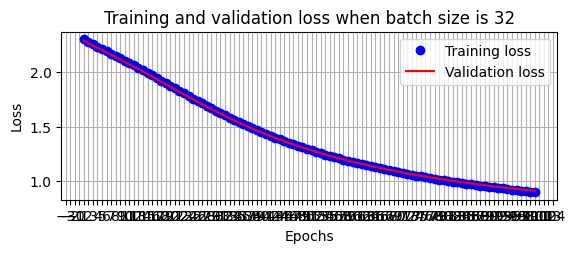

/tmp/ipykernel_5642/2766287155.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


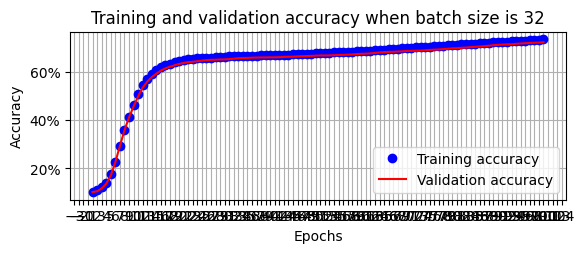

In [58]:
# Now we just train the model like before

# Define the get_data back with 32 of batch size
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

# Train the model with more epochs
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
model, loss_fn, optim = get_model()


# Double the amount of epochs
for epoch in range(100):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []

    # Perform the training on one batch
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        batch_loss = train_batch(x, y, model, optim, loss_fn)
        train_epoch_losses.append(batch_loss)
    # Add to the array
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Same for accuracy
    for _, batch in enumerate(iter(train_dl)):
        x, y = batch

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Now for val
    for _, batch in enumerate(iter(val_dl)):
        x, y = batch

        val_accuracy = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_losses.append(validation_loss)


epochs = np.arange(100)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Checking the impact on a non scaled dataset 

In [61]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

0
1
2
3
4


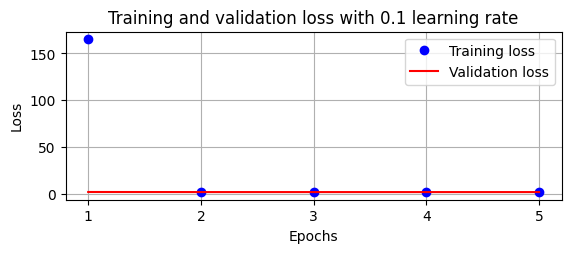

/tmp/ipykernel_5642/3368318854.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


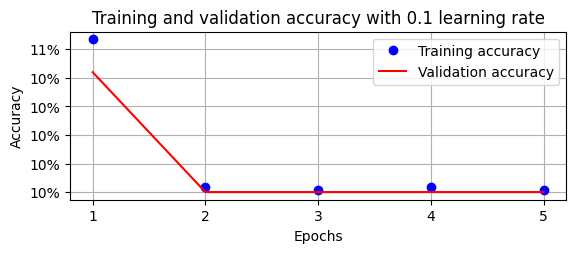

In [62]:
# Now we trained it just like before
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Using a lr_scheduler in Pytorch

In [70]:
from torch import optim
model, loss_fn, optimizer = get_model()
train_dl, val_dl = get_data()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor=0.5,
                                                 patience=0,
                                                 threshold=0.001,
                                                 verbose=True,
                                                 min_lr=1e-5,
                                                 threshold_mode='abs')


In [71]:
# Now we train just like before
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    #print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

Epoch 00002: reducing learning rate of group 0 to 5.0000e-02.
Epoch 00004: reducing learning rate of group 0 to 2.5000e-02.
Epoch 00007: reducing learning rate of group 0 to 1.2500e-02.
Epoch 00009: reducing learning rate of group 0 to 6.2500e-03.
Epoch 00010: reducing learning rate of group 0 to 3.1250e-03.
Epoch 00011: reducing learning rate of group 0 to 1.5625e-03.
Epoch 00012: reducing learning rate of group 0 to 7.8125e-04.
Epoch 00013: reducing learning rate of group 0 to 3.9063e-04.
Epoch 00014: reducing learning rate of group 0 to 1.9531e-04.
Epoch 00015: reducing learning rate of group 0 to 9.7656e-05.
Epoch 00016: reducing learning rate of group 0 to 4.8828e-05.
Epoch 00017: reducing learning rate of group 0 to 2.4414e-05.
Epoch 00018: reducing learning rate of group 0 to 1.2207e-05.
Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.


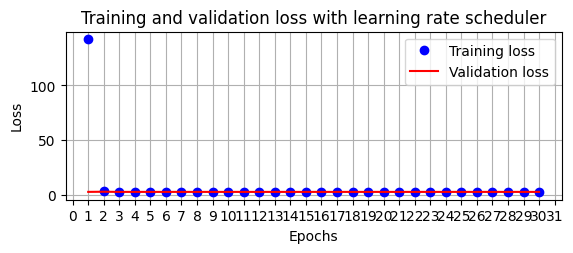

/tmp/ipykernel_5642/3105601407.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


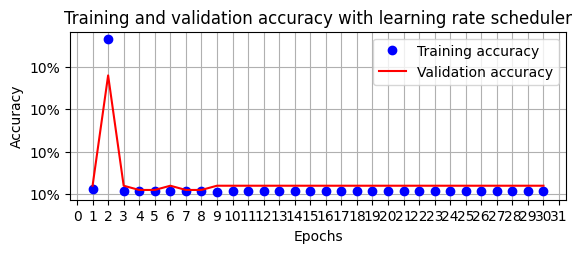

In [72]:
epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Building a deeper neural network

## 2 Hidden layers

In [79]:
# Let's add one hidden layer to our get_model function
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn, optim

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


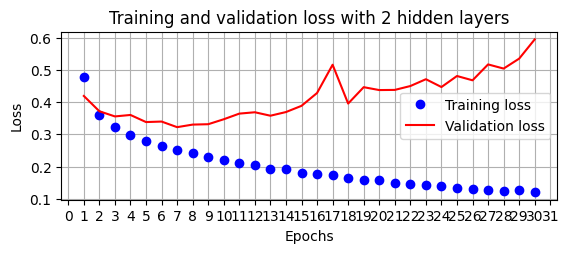

/tmp/ipykernel_5642/2321035280.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


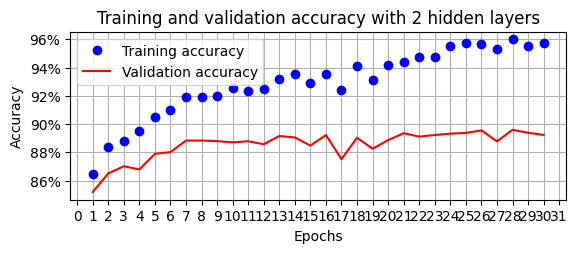

In [80]:
# Now we just train the model
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 2 hidden layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 2 hidden layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## 0 Hidden Layers

In [81]:
# Let's remove all hidden layers of our get_model function
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 10),
    ).to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn, optim

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


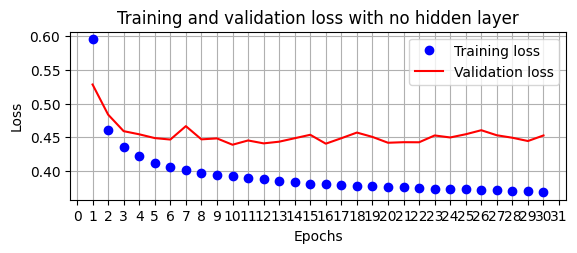

/tmp/ipykernel_5642/2190438026.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


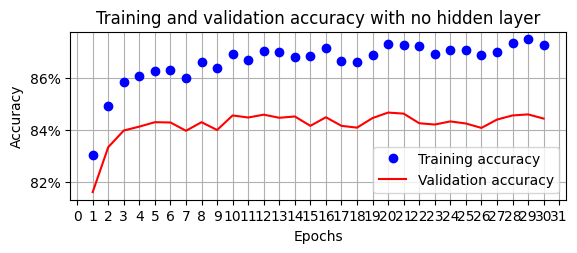

In [82]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)/255
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Batch Normalization 

## Very small input values without batch normalization

In [10]:
from torchvision import datasets
import torch
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import Adam, SGD
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
# Change the normalization done in the dataset class
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255 * 10000)
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# We need to fetch the values of predictions
# and values of the hidden layer, for that
# we must redefine the get_model function
# and intialize it as a nn.Module subclass
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784, 1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x) # these two got initiate
            x2 = self.hidden_to_output_layer(x1) # as different variables 
            return x2, x1                       # so we can check their value
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optim

In [39]:
# We also need to change the accuracy and train_batch functions
# 'cause they're waiting for 1 output from the model, but now the
# model is returning x1 and x2

def train_batch(x, y, model, optim, loss_fn):
    model.train()
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


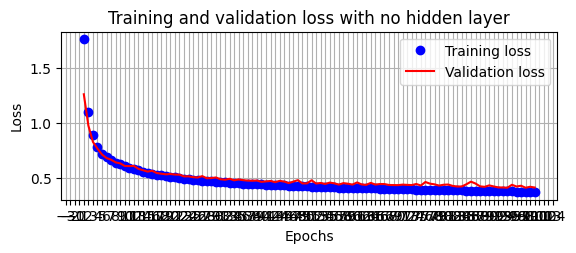

/tmp/ipykernel_25709/3885993094.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


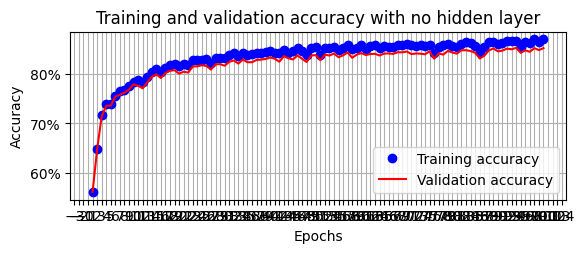

In [40]:

# Now we just train like before

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl


trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(100):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(100)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Very small input values with batch normalization

In [5]:
# Change the normalization done in the dataset class
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255 * 10000)
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# We need to fetch the values of predictions
# and values of the hidden layer, for that
# we must redefine the get_model function
# and intialize it as a nn.Module subclass
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0) # these two got initiate
            x2 = self.hidden_to_output_layer(x1) # as different variables 
            return x2, x1                       # so we can check their value
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


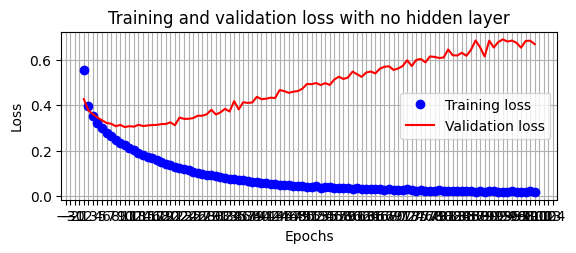

/tmp/ipykernel_8597/1400159110.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


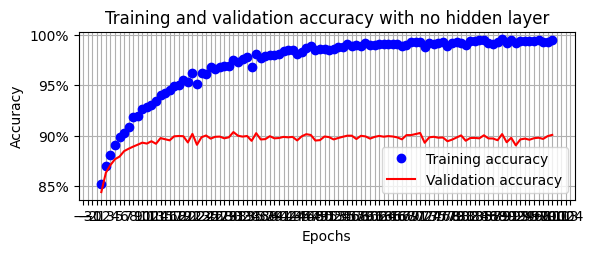

In [6]:
# Now we train it just like before

def train_batch(x, y, model, optim, loss_fn):
    model.train()
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


# Now we just train like before

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl


trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(100):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(100, step=20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# The concept of overfitting

## Adding a dropout 

In [15]:
from torchvision import datasets
import torch
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.optim import SGD, Adam


In [12]:
# Add the dropout layer to our model
def get_model():
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


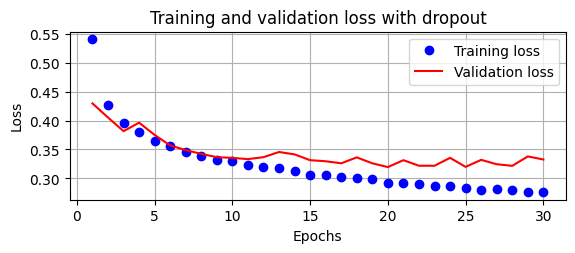

/tmp/ipykernel_31711/3796903337.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


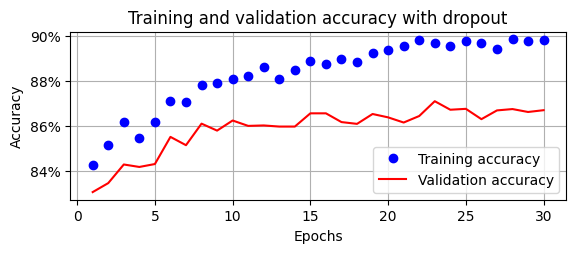

In [16]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)


def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Regularization

### L1 Regularization

In [17]:
# L1 Regulizarization is implemented while training the model, so we must
# Update our train_batch function
def train_batch(x, y, model, optim, loss_fn):
    model.train()
    prediction = model(x)
    l1_regularization = 0
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)
    batch_loss = loss_fn(prediction, y)+0.0001*l1_regularization
    batch_loss.backward()
    optim.step()
    optim.zero_grad()
    return batch_loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


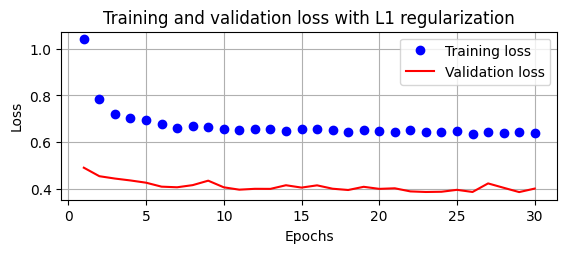

/tmp/ipykernel_31711/2584536370.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


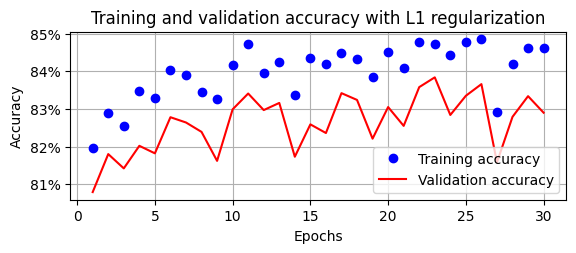

In [18]:
# The rest remains the same
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

trn_dl, val_dl = get_data()
model_l1, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_l1, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_l1)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_l1)
        validation_loss = val_loss(x, y, model_l1)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

### L2 regularization

In [19]:
# Update our train_batch function
def train_batch(x, y, model, optim, loss_fn):
    model.train()
    prediction = model(x)
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 1)
    batch_loss = loss_fn(prediction, y)+0.01*l2_regularization
    batch_loss.backward()
    optim.step()
    optim.zero_grad()
    return batch_loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


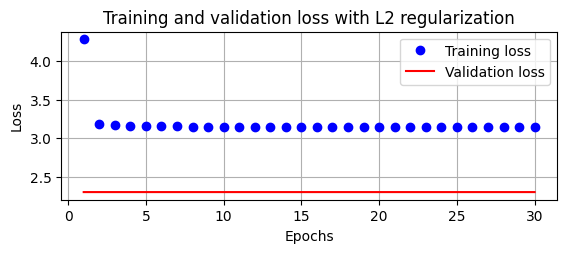

/tmp/ipykernel_31711/1504285608.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


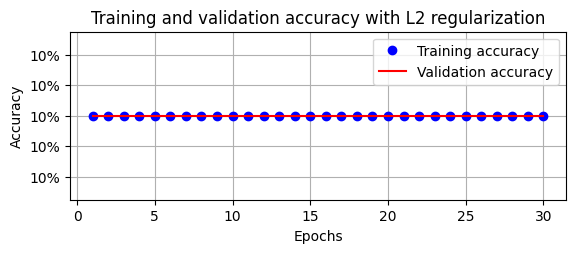

In [20]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

trn_dl, val_dl = get_data()
model_l2, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_l2, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_l2)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_l2)
        validation_loss = val_loss(x, y, model_l2)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


In [ ]:
epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()